In [1]:
import os
import sklearn
import sqlite3
import matplotlib

import numpy as np
import pandas as pd
import enchant as en
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['legend.markerscale'] = 3
matplotlib.rcParams['font.size'] = 16.0

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
spell_check = en.Dict('en_US')

In [3]:
DIR = os.getcwd() + "/../data/"
df = pd.read_csv(DIR + 'raw/lending-club-loan-data/loan.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dealing with missing values


In [4]:
complete_cols = [column for column in df.columns if len(df[column][df[column].isnull()]) == 0]

In [51]:
cols_to_keep = []
to_impute = []

for i in df.columns.values:
    if df[i].isnull().any() == True:
        ok = df[i].isnull().value_counts(sort = False) / len(df[i])
        ok = ok.reset_index()
        # Drop only cols for whom more than the majority (>50%) are missing
        if ok[ok['index'] == False][i].item() > 0.5:
            print "{}\t\t{}".format(i, df[i].dtype)
            to_impute.append(i)
            cols_to_keep.append(i)
    else:
        cols_to_keep.append(i)
        
len(cols_to_keep), len(complete_cols)

emp_title		object
annual_inc		float64
title		object
delinq_2yrs		float64
earliest_cr_line		object
inq_last_6mths		float64
open_acc		float64
pub_rec		float64
revol_util		float64
total_acc		float64
last_pymnt_d		object
next_pymnt_d		object
last_credit_pull_d		object
collections_12_mths_ex_med		float64
acc_now_delinq		float64
tot_coll_amt		float64
tot_cur_bal		float64
total_rev_hi_lim		float64


(53, 35)

#### Imputing missing values: `float64`

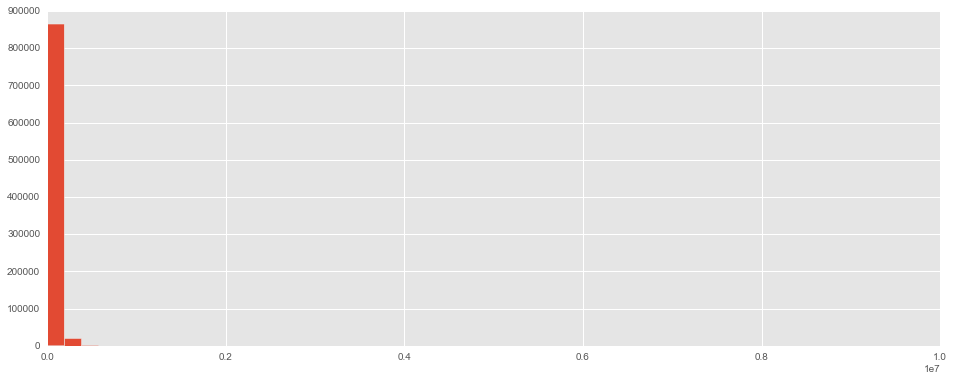

In [25]:
plt.hist(df['annual_inc'].dropna(), bins = 50)
plt.show()

In [52]:
# Drop the people making over $400k a year
df2 = df[df['annual_inc'] <= 400000].copy()
df2.shape, df.shape

((885412, 74), (887379, 74))

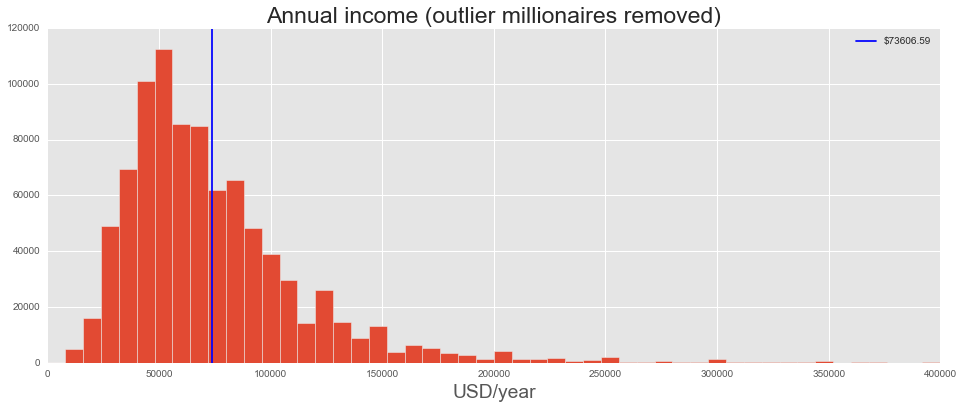

In [58]:
plt.hist(df2['annual_inc'], bins = 50)
plt.axvline(df2['annual_inc'].mean(), label = "${:.2f}".format(df2['annual_inc'].mean()))
plt.title('Annual income (outlier millionaires removed)')
plt.xlabel('USD/year')
plt.legend()
plt.show()

In [63]:
# Since it's just 25 out of 800k, I'll drop
df2['delinq_2yrs'].value_counts(dropna = False)
df3 = df2[df2['delinq_2yrs'].isnull() == False]
df3.shape, df2.shape

((885387, 74), (885412, 74))

In [67]:
df3['inq_last_6mths'].isnull().value_counts()

False    885387
Name: inq_last_6mths, dtype: int64

In [72]:
df3['revol_util'].isnull().value_counts()

False    884920
True        467
Name: revol_util, dtype: int64

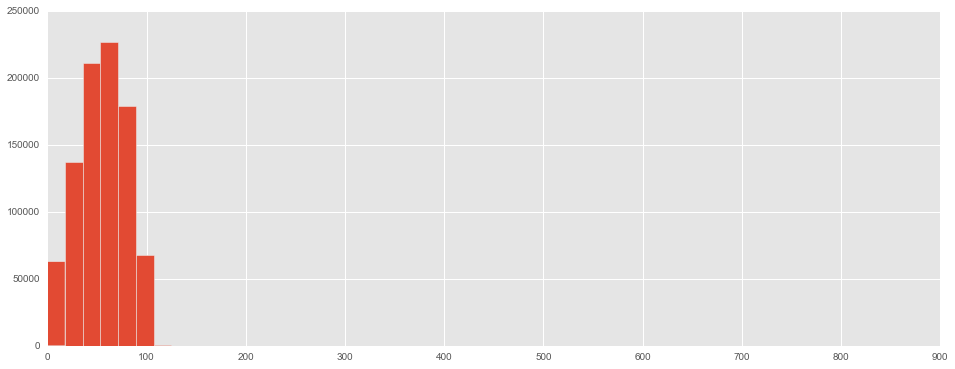

In [76]:
plt.hist(df3['revol_util'].dropna(), bins = 50)
plt.show()

In [83]:
float(df3[df3['revol_util'] > 100].shape[0]) / df3.shape[0]
# Let's drop people using > 100% their credit rate

df4 = df3[df3['revol_util'] <= 130].copy()
df4.shape, df3.shape

((884878, 74), (885387, 74))

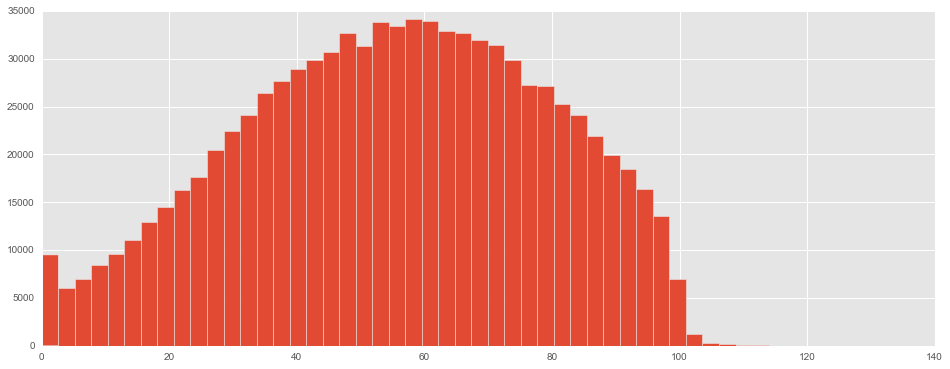

In [84]:
df4['revol_util'].hist(bins = 50)

In [90]:
df5 = df4[df4['collections_12_mths_ex_med'].isnull() == False].copy()
df5.shape, df4.shape

((884766, 74), (884878, 74))

In [105]:
# Imputing using the mean
df5['tot_coll_amt'].fillna(value = df5['tot_coll_amt'].mean(), inplace = True)

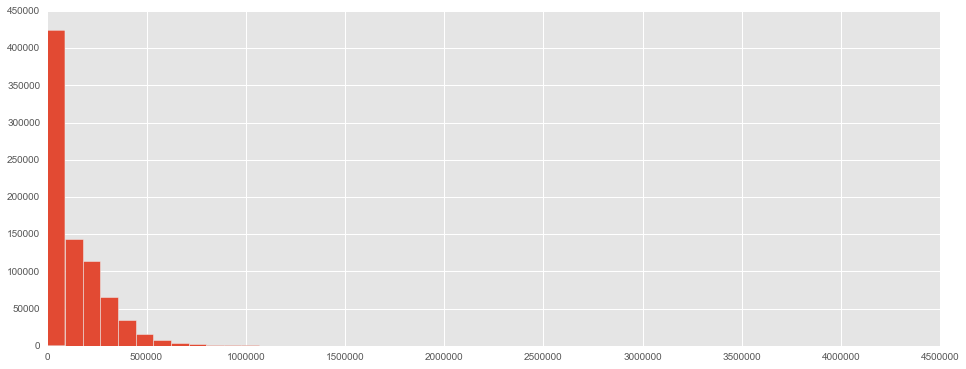

In [110]:
df5['tot_cur_bal'].hist(bins = 50)

In [115]:
df5[df5['tot_cur_bal'].isnull() == True][cols_to_keep].tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
230652,1062400,1294262,20500.0,20500.0,20500.0,36 months,16.77,728.54,D,D2,...,10.21,NaN,Nov-2015,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230653,1059394,1291010,15000.0,15000.0,15000.0,36 months,15.27,521.97,C,C4,...,541.95,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230654,1059224,1290827,35000.0,35000.0,35000.0,36 months,15.96,1229.81,C,C5,...,1244.72,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230655,1058722,1290521,12000.0,12000.0,12000.0,36 months,16.29,423.61,D,D1,...,423.61,NaN,Sep-2012,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230656,1058291,1289878,12000.0,7775.0,7775.0,60 months,15.27,186.08,C,C4,...,186.08,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN


In [116]:
# I think it makes sense to set these to zero - these are people who's current balance is NaN
# because their loan is finished/paid off
df5['tot_cur_bal'].fillna(value = 0, inplace = True)

In [133]:
# Let's just drop this column
cols_to_keep.remove('total_rev_hi_lim')
len(cols_to_keep)

52

In [136]:
df5['earliest_cr_line'].value_counts(dropna = False)

Aug-2001    6647
Aug-2000    6516
Oct-2000    6308
Oct-2001    6141
Aug-2002    6076
Sep-2000    5904
Nov-1999    5861
Oct-1999    5811
Nov-2000    5808
Sep-2002    5803
Oct-2002    5673
Sep-2001    5665
Sep-2003    5603
Aug-1999    5586
Sep-1999    5575
Jul-2001    5320
Nov-2001    5209
Oct-2003    5203
Aug-2003    5193
Mar-2001    5158
Sep-1998    5130
Dec-2000    5091
Sep-2004    5062
May-2001    5056
Dec-2001    5035
Dec-1999    5007
Jul-2000    4979
Oct-1998    4931
Jun-2001    4923
Mar-2000    4895
            ... 
Feb-1960       1
Jul-1955       1
Oct-1954       1
Aug-1958       1
Jul-1961       1
Jun-1949       1
Mar-1955       1
Mar-1958       1
Mar-1959       1
Oct-1950       1
May-1953       1
May-1950       1
May-1961       1
May-1957       1
May-1958       1
Dec-1959       1
Aug-1946       1
Apr-1958       1
Sep-1953       1
Sep-1957       1
Dec-1950       1
Nov-1950       1
Nov-1953       1
Nov-1955       1
Nov-1957       1
Feb-1957       1
Dec-1951       1
Oct-1957      

In [5]:
df['emp_title'].apply(lambda x: spell_check.check(x)).value_counts() / len(df['emp_title'])

False    0.801466
True     0.198534
Name: emp_title, dtype: float64

In [6]:
df['emp_title'].value_counts()

Teacher                                13469
Manager                                11240
Registered Nurse                        5525
Owner                                   5376
RN                                      5355
Supervisor                              4983
Sales                                   4212
Project Manager                         3988
Driver                                  3569
Office Manager                          3510
General Manager                         3178
Director                                3156
manager                                 3138
teacher                                 2925
owner                                   2849
Engineer                                2671
President                               2598
driver                                  2429
Vice President                          2351
Attorney                                2136
Operations Manager                      2071
Accountant                              2035
Administra

In [4]:
catagorical_cols = [
    'application_type', 'initial_list_status',
    'purpose', 'pymnt_plan', 'verification_status',
    'emp_length', 'term'
]

continous_cols =  [
 'loan_amnt','funded_amnt','funded_amnt_inv','installment',
 'dti','revol_bal'
]

y_col = ['int_rate']


In [5]:
df_data = df[catagorical_cols + continous_cols]

In [6]:
# Converted columns to floating point
for feature_name in continous_cols:
    df_data[feature_name] = df_data[feature_name].astype(float)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
data = pd.get_dummies(df_data)

In [8]:
data.tail(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,revol_bal,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_f,initial_list_status_w,...,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,term_ 36 months,term_ 60 months
887376,13000.0,13000.0,13000.0,316.07,30.90,11031.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887377,12000.0,12000.0,12000.0,317.86,27.19,8254.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887378,20000.0,20000.0,20000.0,664.20,10.83,33266.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
x = data.values[:, :]
y = df[y_col].values[:,-1]

In [10]:
# def encode_categorical(array):
#     if not array.dtype == np.dtype('float64'):
#         return LabelEncoder().fit_transform(array) 
#     else:
#         return array
    
# # Categorical columns for use in one-hot encoder
# categorical = (df_data.dtypes.values != np.dtype('float64'))

# # Encode all labels
# data = df_data.apply(encode_categorical)

# # Get numpy array from data
# x = data.values[:, :-1]
# y = data.values[:, -1]

# # Apply one hot endcoing
# encoder = OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
# x = encoder.fit_transform(x)

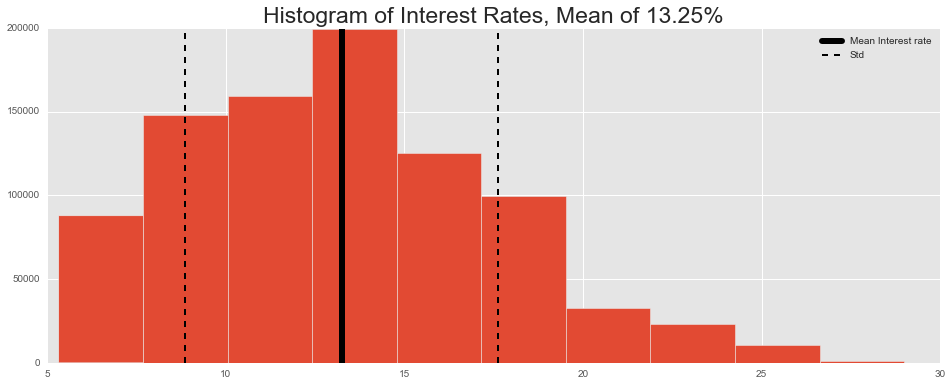

In [11]:
plt.hist(y, bins=10)  # plt.hist passes it's arguments to np.histogram
plt.axvline(np.mean(y), color='black', linestyle='-', lw=6, label='Mean Interest rate')
plt.axvline(np.mean(y) - np.std(y), color='black', linestyle='--', lw=2, label='Std')
plt.axvline(np.mean(y) + np.std(y), color='black', linestyle='--', lw=2)
plt.title("Histogram of Interest Rates, Mean of {:0.2f}%".format(np.mean(y)))
plt.legend()
plt.show()

In [12]:
%%bash
say 'Done'

In [13]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Ridge

I tried using LASSO, it took too long.

Regulaization doesn't seem to improve the error

In [63]:
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

scores_ridge = list()
scores_std_ridge = list()

ridge = Ridge()
coefs = []
errors = []

alphas = np.logspace(-6, 6, 20)

# Train the model with different regularisation strengths
for a in alphas:
    ridge.set_params(alpha=a)
    this_scores = cross_val_score(ridge, X_train, y_train, cv=3, n_jobs=1)
    scores_ridge.append(np.mean(this_scores))
    scores_std_ridge.append(np.std(this_scores))

(9.9999999999999995e-07, 1000000.0)

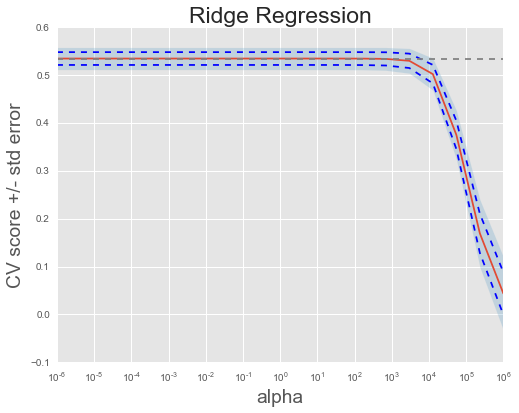

In [24]:
scores_ridge, scores_std_ridge = np.array(scores_ridge), np.array(scores_std_ridge)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores_ridge)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std_ridge / np.sqrt(3)

plt.semilogx(alphas, scores_ridge + std_error, 'b--')
plt.semilogx(alphas, scores_ridge - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores_ridge + scores_std_ridge, scores_ridge - scores_std_ridge, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.title('Ridge Regression')
plt.axhline(np.max(scores_ridge), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

linreg = LinearRegression()

linreg.fit(X_train, y_train)

prediction = linreg.predict(X_test)

print(linreg.score(X_test, y_test))

print(mean_squared_error(prediction, y_test))

0.54677017964
8.72374023156


In [58]:
print('Intercept: {:0.2f}'.format(linreg.intercept_))

Intercept: 17.70


In [57]:
print('Coeff')
pd.DataFrame.from_dict(dict(zip(data.columns, linreg.coef_)), orient='index').T

Coeff


,funded_amnt_inv,emp_length_n/a,purpose_wedding,emp_length_7 years,purpose_house,purpose_medical,verification_status_Verified,application_type_JOINT,revol_bal,purpose_other,...,purpose_small_business,purpose_major_purchase,purpose_vacation,emp_length_2 years,pymnt_plan_y,purpose_credit_card,emp_length_1 year,emp_length_8 years,emp_length_10+ years,purpose_debt_consolidation
0,0.000042,0.014402,-0.108279,0.05202,0.67065,0.718338,0.657788,0.12279,-0.000006,0.788298,...,0.619513,-1.061428,1.252798,0.041809,0.00997,-1.628181,0.078514,-0.056309,-0.095276,-0.798157


In [67]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 2.016e+04
Date:                Sat, 26 Nov 2016   Prob (F-statistic):               0.00
Time:                        23:57:22   Log-Likelihood:            -1.4845e+06
No. Observations:              594543   AIC:                         2.969e+06
Df Residuals:                  594506   BIC:                         2.969e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0003    1.2e-05    -27.602      0.0

# Baseline

In [62]:
base_line = [np.mean(y)]*len(y_test)
print('R^2 : {}'.format(r2_score(base_line, y_test)))
print('Meansquared error: {} '.format(mean_squared_error(base_line, y_test)))

R^2 : -3.8124522478882046e+29
Meansquared error: 19.24796500083821 


# Ada

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),
                          n_estimators=300, random_state=0)

ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=0)

In [78]:
ada.score(X_test, y_test)

0.23232151180906613

In [79]:
print('Feature Importances')
pd.DataFrame.from_dict(dict(zip(data.columns, ada.feature_importances_)), orient='index')

Feature Importances


,0
funded_amnt_inv,0.000000
emp_length_n/a,0.000000
purpose_wedding,0.000000
emp_length_7 years,0.000000
purpose_house,0.000000
purpose_medical,0.000000
verification_status_Verified,0.071393
application_type_JOINT,0.000000
revol_bal,0.023052
purpose_other,0.014412
